In [19]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon
import numpy as np


In [20]:
df = pd.read_json("../input/Restor_Eco/restor_eco.json")
df.head(3)

,id,name,description,polygon,siteType,siteVisibility,surfaceAreaKm2,countryCode,interventionStartYear,stage,...,landTenureUrl,photoIds,customFields,customLinkUrl,customLinkText,donateUrl,analysis,isFeatured,createdAt,updatedAt
0,3eec6174-21ce-4cb0-9180-82c1ccbef0bb,[Mabale - Holistic land management site SFA],{},"{'type': ['MultiPolygon'], 'coordinates': [[[[...",[LANDSCAPE],[PUBLIC],[104.9347],[ZW],[2021],[ONGOING],...,{},[],[],{},{},{},{},[False],[2023-02-23T12:18:27.313Z],[2023-02-23T12:18:27.313Z]
1,6bbc2d6c-ce35-48b2-9fd4-af74030f7fda,[Lukango Tree Conservancy Limited (LuTreeCo)],[Lukango Tree Conservancy Limited (LuTreeCo) i...,"{'type': ['MultiPolygon'], 'coordinates': [[[[...",[RESTORATION],[PUBLIC],[0.3275],[UG],[2017],[ONGOING],...,{},"[1bfa2bcd-6505-405d-abf7-6bbc8113fde6, dc0ff07...",[],{},{},{},{},[False],[2023-04-11T08:54:50.837Z],[2023-04-11T14:01:54.154Z]
2,bccf3ff8-cc4e-47f2-9435-aaaa5ff9a89c,[Lilongwe (Not entire City)],[This is the city of Lilongwe which we have do...,"{'type': ['MultiPolygon'], 'coordinates': [[[[...",[RESTORATION],[PUBLIC],[362.3797],[MW],[2022],[ONGOING],...,{},[],[],{},{},{},{},[False],[2023-02-27T14:42:54.442Z],[2023-02-27T14:48:17.999Z]


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1540 entries, 0 to 1539
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   id                         1540 non-null   object
 1   name                       1540 non-null   object
 2   description                1540 non-null   object
 3   polygon                    1540 non-null   object
 4   siteType                   1540 non-null   object
 5   siteVisibility             1540 non-null   object
 6   surfaceAreaKm2             1540 non-null   object
 7   countryCode                1540 non-null   object
 8   interventionStartYear      1540 non-null   object
 9   stage                      1540 non-null   object
 10  preInterventionLandUse     1540 non-null   object
 11  interventionType           1540 non-null   object
 12  postInterventionLandCover  1540 non-null   object
 13  siteManagement             1540 non-null   object
 14  siteOwne

### Fix geometries

In [22]:
df['geometry'] = df['polygon'].apply(lambda x: MultiPolygon([shape({'type': 'Polygon', 'coordinates': poly}) for poly in x['coordinates']]) if isinstance(x, dict) and 'type' in x and 'coordinates' in x else Polygon())

In [23]:
gdf = gpd.GeoDataFrame(df, geometry = 'geometry', crs = 'EPSG:4326')
gdf['geometry'] = gdf['geometry'].make_valid()

In [24]:
gdf = gdf.explode(index_parts = False)

In [25]:
gdf = gdf[(gdf.geometry.geom_type == 'Polygon') | (gdf.geometry.geom_type == 'MultiPolygon')]
gdf = gdf.explode(index_parts = False)
gdf = gdf.reset_index(drop = True)

<Axes: >

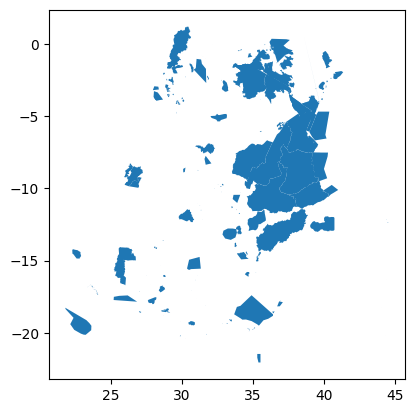

In [26]:
gdf.plot()

### Harmonize nomenclature

In [27]:
gdf['site_sqkm'] = gdf['geometry'].to_crs(3857).area / 1e6
gdf['site_sqkm'].describe()

count    1.741000e+03
mean     5.587645e+02
std      4.384503e+03
min      1.295923e-15
25%      7.684348e-03
50%      2.081895e-02
75%      4.446359e-01
max      7.503590e+04
Name: site_sqkm, dtype: float64

In [28]:
gdf['country'] = gdf['countryCode'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '')

In [29]:
# Renaming the columns to follow our naming format in the paper columns section
columns_rename_mapping = {
    'id': 'project_id_reported',
    'description': 'project_description_reported',
    'interventionStartYear': 'planting_date_reported',
    'website': 'url'
}
gdf.rename(columns=columns_rename_mapping, inplace=True)

In [30]:
gdf['project_description_reported'] = gdf['project_description_reported'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '')
gdf['planting_date_reported'] = gdf['planting_date_reported'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '')
gdf['url'] = gdf['url'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '')

In [31]:
columns_to_keep = [
     'project_id_reported',
    'project_description_reported',
     'planting_date_reported',
     'geometry',
     'url',
     'site_sqkm',
     'country'
]
gdf=gdf[columns_to_keep]

In [32]:
gdf['planting_date_reported'] = gdf['planting_date_reported'].replace('', np.nan).astype(float)

/var/folders/_l/gj90rjl90fngb4_8ph5x5jhc0000gn/T/ipykernel_43987/2687931294.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf['planting_date_reported'] = gdf['planting_date_reported'].replace('', np.nan).astype(float)
/Users/angela/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [33]:
gdf['site_id_reported'] = ['restor_site_{}'.format(i) for i in range(1, len(gdf) + 1)]
gdf ['host_name'] = 'Restor Eco'
gdf['url'] = 'https://restor.eco/sites/' + gdf['project_id_reported'].astype(str)

gdf = gdf.assign(species_count_reported=None, species_planted_reported=None, survival_rate_reported=None,trees_planted_reported=None)
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   project_id_reported           1741 non-null   object  
 1   project_description_reported  1741 non-null   object  
 2   planting_date_reported        960 non-null    float64 
 3   geometry                      1741 non-null   geometry
 4   url                           1741 non-null   object  
 5   site_sqkm                     1741 non-null   float64 
 6   country                       1741 non-null   object  
 7   site_id_reported              1741 non-null   object  
 8   host_name                     1741 non-null   object  
 9   species_count_reported        0 non-null      object  
 10  species_planted_reported      0 non-null      object  
 11  survival_rate_reported        0 non-null      object  
 12  trees_planted_reported        0 non-null

/Users/angela/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/angela/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/angela/Library/Python/3.9/lib/python/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [36]:
gdf["url"][0]

'https://restor.eco/sites/3eec6174-21ce-4cb0-9180-82c1ccbef0bb'

### Save it

In [35]:
gdf.to_file('../midsave/restor_eco.gpkg')